# TPCRP Algorithm Implementation

In [26]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader
from scipy.spatial.distance import cdist

# Feature Extraction

In [27]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=1000, shuffle=True)

Use the pre-trained **ResNet18** model to extract feature embeddings.

In [28]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet18(pretrained=True)
model.fc = torch.nn.Identity()  # Remove classification layer

# Move model to GPU before setting to eval mode
model.to(device)
model.eval()  

def extract_features(data_loader, model, device="cuda"):
    model.to(device)
    model.eval()
    features = []
    
    with torch.no_grad():
        for images, _ in data_loader:
            images = images.to(device)  # Move images to GPU
            output = model(images)
            features.append(output.cpu().numpy())  # Move back to CPU for clustering
            
    return np.vstack(features)

features = extract_features(train_loader, model)

/home/mateo/ML-coursework2/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/mateo/ML-coursework2/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


# K-Means Clustering

In [29]:
L_size = 50   # Number of already labeled examples (|L|)
B = 20        # Budget (New samples to be labeled)
num_clusters = L_size + B


# K-Means Clustering 
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
labels = kmeans.fit_predict(features)

# Selecting Typical Examples

In [30]:
def select_typical_examples(features, labels):
    """Compute Typicality using all points in the same cluster"""
    selected_indices = []
    
    for cluster_id in np.unique(labels):
        cluster_indices = np.where(labels == cluster_id)[0]
        cluster_features = features[cluster_indices]
        
        # Compute pairwise distances within the cluster
        distances = cdist(cluster_features, cluster_features, metric="euclidean")
        
        # Compute Typicality: (1 / Mean Distance to All Other Points in Cluster)
        typicality_scores = np.reciprocal(np.mean(distances, axis=1))
        
        # Select the most typical sample (highest typicality score)
        best_index = cluster_indices[np.argmax(typicality_scores)]
        selected_indices.append(best_index)
    
    return selected_indices

selected_samples = select_typical_examples(features, labels)
print("Selected sample indices:", selected_samples)

Selected sample indices: [np.int64(35665), np.int64(34517), np.int64(14663), np.int64(38991), np.int64(16332), np.int64(35724), np.int64(24647), np.int64(19189), np.int64(33553), np.int64(29722), np.int64(37660), np.int64(23740), np.int64(6056), np.int64(21751), np.int64(40581), np.int64(39294), np.int64(41818), np.int64(23419), np.int64(11367), np.int64(21951), np.int64(23609), np.int64(49020), np.int64(21778), np.int64(7637), np.int64(9299), np.int64(32720), np.int64(10579), np.int64(14496), np.int64(3940), np.int64(15734), np.int64(34036), np.int64(37304), np.int64(35761), np.int64(20793), np.int64(8484), np.int64(32447), np.int64(37505), np.int64(35406), np.int64(612), np.int64(39505), np.int64(9432), np.int64(45380), np.int64(12438), np.int64(13450), np.int64(19469), np.int64(31718), np.int64(37502), np.int64(11118), np.int64(17238), np.int64(2580), np.int64(49236), np.int64(30501), np.int64(4392), np.int64(3087), np.int64(11100), np.int64(10133), np.int64(35973), np.int64(45494),

# Visualisation

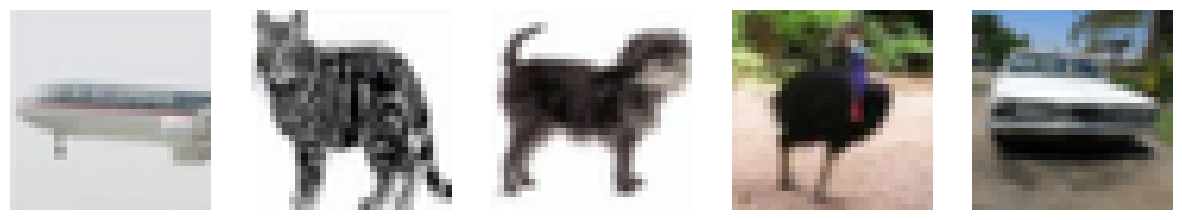

In [40]:
def show_images(dataset, indices, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)):
    """Show images after denormalization"""
    fig, axes = plt.subplots(1, len(indices), figsize=(15, 3))
    for ax, idx in zip(axes, indices):
        image, _ = dataset[idx]
        image = image.numpy().transpose(1, 2, 0)  # Convert (C, H, W) to (H, W, C)
        image = image * std + mean  # De-normalize
        image = np.clip(image, 0, 1)
        ax.imshow(image)
        ax.axis('off')
    plt.show()

show_images(train_dataset, selected_samples[:5])